In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import os
import numpy as np
import pandas as pd
import elevation
import elevation.prediction_pipeline as pp
import elevation.aggregation
from IPython.core.debugger import Tracer
import matplotlib.pyplot as plt
np.random.seed(123) 
import scipy.stats as st
import pickle
#import seaborn
import matplotlib
import azimuth.util
import sklearn
import copy
import sklearn.cross_validation
import sklearn.ensemble
import sklearn.linear_model
from sklearn.grid_search import GridSearchCV
import elevation.aggregation
reload(elevation.aggregation)

<module 'elevation.aggregation' from 'c:\dev\elevation\elevation\aggregation.pyc'>

In [2]:
# how this was loaded:
# with open(savefile + "_groupby_nonagg.p", 'wb') as f:  pickle.dump([all_predictions, gene_names, off_target_seq, models_to_calibrate], f)

# with open('\\\\nerds5\\compbio_storage\\CRISPR.offtarget\\gecko_new.calib1_ctnm1.3MM.v10.N9919088_groupby_nonagg_small.p', 'rb') as f:
with open('\\\\nerds5\\compbio_storage\\CRISPR.offtarget\\gecko_new.calib1_ctnm1.3MM.v10.N9919088_groupby_nonagg.p', 'rb') as f:
    results_gecko = pickle.load(f)# with open('/mnt/nerds5_genetics/CRISPR.offtarget/allsitesGecko.calib0_countnormTrue.v7.gbrtw1.00e+02.N3137128_groupby_nonagg_small.p', 'rb') as f:

In [3]:
new_gecko_df = pd.read_csv('C:\\dev\\CRISPR\\data\\Mudra_clean.2017-04-10\\GeCKOv2_essential_nonessential_v4.csv')
celltypes = new_gecko_df['Cell Type'].unique()
original_celltypes = celltypes
celltypes = map(lambda x: x.split("_")[0], celltypes)
celltype_map = dict(zip(celltypes, original_celltypes))

In [4]:
# test everything is equal
seq_by_celltype = {}
for celltype, ocelltype in zip(celltypes, original_celltypes):
    print celltype, ocelltype
    seq_by_celltype[celltype] = np.sort(new_gecko_df[new_gecko_df['Cell Type'] == ocelltype]['sgRNA context sequence'].dropna(how="any").apply(lambda x: x[4:20+4+3]).values)

A375 A375_SKIN
A673 A673_BONE
BXPC3 BXPC3_PANCREAS
CADOES1 CADOES1_BONE
CAL120 CAL120_BREAST
COLO741 COLO741_SKIN
CORL105 CORL105_LUNG
EW8 EW8_BONE
EWS502 EWS502_BONE
G402 G402_SOFT_TISSUE
HCC44 HCC44_LUNG
HS294T HS294T_SKIN
HT29 HT29_LARGE_INTESTINE
K562 K562_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE
L33 L33_PANCREAS
LNCAPCLONEFGC LNCAPCLONEFGC_PROSTATE
MEWO MEWO_SKIN
MHHES1 MHHES1_BONE
NCIH1373 NCIH1373_LUNG
NCIH2009 NCIH2009_LUNG
PANC0327 PANC0327_PANCREAS
PANC0813 PANC0813_PANCREAS
PANC1 PANC1_PANCREAS
PATU8902 PATU8902_PANCREAS
PATU8988T PATU8988T_PANCREAS
PC3 PC3_PROSTATE
RDES RDES_BONE
SKES1 SKES1_BONE
SU8686 SU8686_PANCREAS
T47D T47D_BREAST
TC32 TC32_BONE
TC71 TC71_BONE
TOV112D TOV112D_OVARY


In [5]:
curr_set = None
for k, v in seq_by_celltype.iteritems():
    if curr_set is not None:
        assert curr_set.symmetric_difference(set(v)) == set()
    curr_set = set(v)
print len(curr_set)
new_set = curr_set

curr_set = None
for method in results_gecko[0]:
    next_set = set(results_gecko[0][method].keys())
    if curr_set is not None:
        assert curr_set.symmetric_difference(next_set) == set()
    curr_set = next_set
print len(curr_set)
old_set = curr_set

results_gecko_sequences = set(results_gecko[2].keys())
assert results_gecko_sequences == old_set
assert results_gecko_sequences - new_set == set()
print len(results_gecko_sequences)

102354
4537
4537


In [6]:
gecko_offtarget_df = pd.read_csv('C:\\dev\\dnase_elevation\\gecko_offtargets.csv')

In [7]:
gecko_offtarget_dict = {ontarget: {} for ontarget in gecko_offtarget_df['ontarget'].unique()}
for ontarget, offtarget, c, s, e in gecko_offtarget_df[['ontarget', 'offtarget', 'chromosome', 'start', 'end']].values:
    gecko_offtarget_dict[ontarget][offtarget] = (c, s, e)

In [8]:
results_gecko_coordinates = {k: [] for k in results_gecko[2]}
for ontarget in results_gecko[2]:
    assert (set(results_gecko[2][ontarget]) - set(gecko_offtarget_dict[ontarget].keys())) == set()
    for offtarget in results_gecko[2][ontarget]:
        results_gecko_coordinates[ontarget].append(gecko_offtarget_dict[ontarget][offtarget])

In [9]:
class DnaseRegions(object):

    def __init__(self, filename, check_data=False):
        self.filename = filename
        self.df = pd.read_csv(filename, delimiter="\t")
        self.chromosomes = self.df['chrom'].unique()
        self.data = self.build_data()
        if check_data:
            self.do_check_data()

    def build_data(self):
        data = {chrom: self.df[self.df['chrom'] == chrom][['chromStart', 'chromEnd', 'signalValue']].sort_values(by='chromStart').values.T for chrom in self.chromosomes}
        return data

    def do_check_data(self):
        for chrom in self.data:
            values = self.data[chrom]
            prev = None
            for start, end, signalValue in values.T:
                if prev is None:
                    prev = start, end
                    continue
                assert prev[1] <= start
                prev = start, end

    def find(self, chrom_num, qstart, qend):

        def b(t, a, p=0):
            if len(a) == 0:
                return p
            i = len(a)//2
            if t < a[i]:
                return b(t, a[:i], p)
            if t > a[i]:
                return b(t, a[i+1:], p + i + 1)
            return p + i

        chrom = "chr%s" % chrom_num
        if chrom not in self.data:
            return None

        start_values, end_values, signals = self.data[chrom]
        pos = b(qstart, start_values)

        if pos == start_values.shape[0] or (pos == 0 and qstart < start_values[pos]):
            return None

        # b returns insertion position s.t. t <= a[p]
        # we want a[p] <= t
        if start_values[pos] != qstart and start_values[pos-1] <= qstart:
            pos -= 1

        assert start_values[pos] <= qstart, "%s <= %s" % (start_values[pos], qstart)
        if qend <= end_values[pos]:
            return signals[pos]
        else:
            return None

def get_filename(cell_type):
    filename = pk_dfs = {
        "AVG": "C:\\dev\\dnase_elevation\\average_pk.txt",
        "K562": "C:\\dev\\dnase_elevation\\k562_pk.txt",
        "PANC1": "C:\\dev\\dnase_elevation\\panc1_pk.txt",
        "T47D": "C:\\\dev\\dnase_elevation\\t47d_pk.txt",
    }[cell_type]
    return filename


In [10]:
# available cell types
# target_celltype = "A375"
# target_celltype = "K562"
# target_celltype = "PANC1"
target_celltype = "T47D"

In [11]:
# load and identify dnase
dnase = DnaseRegions(get_filename("AVG"), check_data=True)
# dnase = DnaseRegions(get_filename(target_celltype), check_data=True)
results_gecko_dnase_original = {k: [] for k in results_gecko[2]}
for ontarget in results_gecko_coordinates:
    for c, s, e in results_gecko_coordinates[ontarget]:
        value = dnase.find(c, s, e)
        results_gecko_dnase_original[ontarget].append(value)

In [12]:
total_len = 0
zero_len = 0
none_len = 0
for ontarget in results_gecko_dnase_original:
    for item in results_gecko_dnase_original[ontarget]:
        total_len += 1
        if item is None:
            none_len += 1
        elif item == 0.0:
            zero_len += 1
print total_len, zero_len, none_len, total_len - none_len

9683973 0 8618428 1065545


In [13]:
# impute
impute_dnase_value = 1.0/95
results_gecko_dnase = copy.deepcopy(results_gecko_dnase_original)
for ontarget in results_gecko_dnase:
    results_gecko_dnase[ontarget] = np.array(results_gecko_dnase[ontarget], dtype=np.float32)
    results_gecko_dnase[ontarget][np.isnan(results_gecko_dnase[ontarget])] = impute_dnase_value

In [14]:
# load gecko
def load_celltype(cell_type):
    df_fn = 'C:\\dev\\CRISPR\\data\\Mudra_clean.2017-04-10\\GeCKOv2_essential_nonessential_v4.csv'
    df = pd.read_csv(df_fn)
    target_celltypes = ["A375", "K562", "PANC1", "T47D"]
    all_celltypes = df["Cell Type"].unique()
    celltype_names = []
    for tct in target_celltypes:
        for act in all_celltypes:
            if act.find(tct) != -1:
                celltype_names.append((tct, act))
    for tct, act in celltype_names:
        if tct == cell_type:
            target_df = df[df["Cell Type"] == act]
            target_df['celltype'] = cell_type
            break

    isviability = target_df["Assay Type"].apply(lambda x: "viability" in x if isinstance(x, basestring) else False)
    isnot_essential = target_df['Non-Essential genes'] == "Y"
    viable_and_essential = (isviability & isnot_essential) | (~isviability)
    target_df = target_df[viable_and_essential]
    return target_df

In [15]:
print target_celltype
MAX_VALUE_JOHN = 1000
#with open('/mnt/nerds5_genetics/CRISPR.offtarget/allsitesGecko, 'rb') as f:
# with open('/mnt/nerds5_genetics/CRISPR.offtarget/allsitesGecko_allmodels_calib0_countnormTrue.N3137128_groupby_nonagg.p', 'rb') as f:
#    results_gecko_v6 = pickle.load(f)

mit_gecko = pd.read_excel('../../CRISPR/data/offtarget/GeCKOv2_Non_essentials_Achilles_A375_complete.xls')
mit_gecko = mit_gecko[['offtarget_score', 'sgRNA measured value', 'sgRNA Sequence']].dropna()
st.spearmanr(mit_gecko['offtarget_score'], mit_gecko['sgRNA measured value'])

# gecko_data = pd.read_csv('../../CRISPR/data/offtarget/3MM_michael/GeCKOv2_Non_essentials_Achilles_A375.txt', delimiter='\t')

# gecko_data = load_celltype("A375")
gecko_data = load_celltype(target_celltype)
gecko_data = gecko_data.dropna(how="any", subset=['sgRNA context sequence'])
gecko_data['sgRNA measured value'] = -gecko_data['sgRNA measured value']

gecko_data['full_seq'] = gecko_data['sgRNA context sequence'].apply(lambda x: x[4:20+4+3])
gecko_data['A375 Percent rank'] = gecko_data['sgRNA measured value']
gecko_merged = pd.merge(gecko_data, mit_gecko, left_on='sgRNA Sequence', right_on='sgRNA Sequence')

jd_gecko = pd.read_excel('../../CRISPR/data/offtarget/GeCKOv2_Non_essentials_Achilles_A375_updated.xls')
#jd_gecko['full_seq'] = jd['sgRNA Sequence'] + jd['PAM Sequence']
# jd_gecko = jd_gecko[['sgRNA Sequence', 'Broad_John_bin_average', 'full_seq']].set_index(['full_seq'])
# jd = jd.loc[jd['T1 MB12'] != 'MAX']
jd_gecko = jd_gecko[['sgRNA Sequence', 'Broad_John_bin_average']].replace([np.inf, -np.inf], MAX_VALUE_JOHN).dropna()
print gecko_merged.shape
print jd_gecko.shape
gecko_merged = pd.merge(gecko_merged, jd_gecko, on=['sgRNA Sequence'])
print gecko_merged.shape

T47D


C:\Users\v-huelib\AppData\Local\Continuum\Anaconda2\envs\elevation\lib\site-packages\ipykernel\__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(4685, 34)
(4039, 2)
(4029, 35)


In [16]:
def aggregator_features(results, mit_results, N=None, methods=['product', 'CFD', 'linear-raw-stacker', 'MIT', 'ensemble', 'HsuZhang'], which='old'):
    truth = []
    broad = []
    mean = dict((m, []) for m in methods)
    score = dict((m, []) for m in methods)
    raw = dict((m, []) for m in methods)
    skipped = 0
    if N is None:
        N = min(len(results[1].keys()), mit_results.shape[0])
    # N = min(N, len(results[1].keys()), mit_results.shape[0])
    
    D = 30

    features = dict((m, np.zeros((N, D))) for m in methods) # 46, 18
    features['ensemble'] = np.zeros((N, D*2))
    if 'ensemble_1' in methods:
        features['ensemble_1'] = np.zeros((N, D*2))
    if 'ensemble_2' in methods:
        features['ensemble_2'] = np.zeros((N, D*4))
    if 'ensemble_3' in methods:
        features['ensemble_3'] = np.zeros((N, D*3))
    if 'ensemble_4' in methods:
        features['ensemble_4'] = np.zeros((N, D*5))

    guides = []
    # pdf = np.exp(kd.score_samples(Xgs[:, None]))
    i = 0
    #for g in results[1].keys():
    for g in mit_results['full_seq'].values:

        if i % 1000 == 0:
            print i, mit_results.shape[0]

        if not (g in results[0]['linear-raw-stacker'] and g in results[0]['CFD']):
            skipped += 1
            continue

        if i >= N:
            break

        try:
            for method in methods:
                if method == 'MIT':
                    mean[method].append(mit_results[mit_results['full_seq'] == g]['offtarget_score'].values[0])
                    score[method].append(mit_results[mit_results['full_seq'] == g]['offtarget_score'].values[0])
                elif method == 'broad':
                    score[method].append(-mit_results[mit_results['full_seq'] == g]['Broad_John_bin_average'].values[0])
                elif method == 'ensemble':
                    genic_g = np.array(results[1][g]) != 'NoGene' 
                    features[method][i], names = elevation.aggregation.get_stats(np.array(results[0]['linear-raw-stacker'][g]), 
                                                                          np.array(results[0]['CFD'][g]), genic_g)
                elif method == 'ensemble_1':
                    genic_g = np.array(results[1][g]) != 'NoGene' 
                    dnase = results_gecko_dnase[g]
                    features[method][i], names = elevation.aggregation.get_stats_dnase(
                        np.array(results[0]['linear-raw-stacker'][g]), 
                        np.array(results[0]['CFD'][g]), 
                        dnase,
                        genic_g, 1)
                elif method == 'ensemble_2':
                    genic_g = np.array(results[1][g]) != 'NoGene' 
                    dnase = results_gecko_dnase[g]
                    features[method][i], names = elevation.aggregation.get_stats_dnase(
                        np.array(results[0]['linear-raw-stacker'][g]), 
                        np.array(results[0]['CFD'][g]), 
                        dnase,
                        genic_g, 2)
                elif method == 'ensemble_3':
                    genic_g = np.array(results[1][g]) != 'NoGene' 
                    dnase = results_gecko_dnase[g]
                    features[method][i], names = elevation.aggregation.get_stats_dnase(
                        np.array(results[0]['linear-raw-stacker'][g]), 
                        np.array(results[0]['CFD'][g]), 
                        dnase,
                        genic_g, 3)
                elif method == 'ensemble_4':
                    genic_g = np.array(results[1][g]) != 'NoGene' 
                    dnase = results_gecko_dnase[g]
                    features[method][i], names = elevation.aggregation.get_stats_dnase(
                        np.array(results[0]['linear-raw-stacker'][g]), 
                        np.array(results[0]['CFD'][g]), 
                        dnase,
                        genic_g, 4)
                elif method == 'HsuZhang':
                    t = np.array(results[0][method][g])
                    preds_g = t
                    score[method].append(100./(100 + np.sum(preds_g)))
                else:
                    t = np.array(results[0][method][g])
                    # if method == 'linear-raw-stacker':
                    #    a,b,c,d,f = [-0.40317539,  0.48128055,  0.6186926 ,  0.14710948,  0.78741327]

                    #    # avana = [ 1.26015589, -0.01607083,  4.17914254,  0.39207014, -0.30867801]
                    #    t =  a + b*t + c*np.tanh(d*t + f)
                    #    # print "WARNING: warping based on Avana values"
                    preds_g = t
                    genic_g = np.array(results[1][g]) != 'NoGene' 

                    mean[method].append(np.mean(preds_g[genic_g]))
                    score[method].append(np.sum(preds_g[genic_g])/float(len(preds_g)))


                    if which == 'old':
                        features[method][i] = elevation.aggregation.get_stats(preds_g, genic_g)
                    elif which == 'new':
                        features[method][i] = elevation.aggregation.get_stats(preds_g, genic_g)
                    else:
                        sorted_bo = np.sort(preds_g)
                        yvals_bo = np.arange(len(sorted_bo))/float(len(sorted_bo))
                        features[method][i] = yvals_bo[np.logspace(np.log10(2), np.log10(len(yvals_bo)), 50, dtype=int)-1]

                    raw[method].append((preds_g, genic_g))

                    # reference_guide = mit_results.iloc[mit_results['A375 Percent rank'].idxmin()].full_seq
                    # reference_offtargets = np.array(results[0][method][reference_guide])
                    # genic_reference = np.array(results[1][reference_guide]) != 'NoGene'
                    #bad_guide = mit_results.iloc[mit_results['A375 Percent rank'].idxmax()].full_seq
                    #bad_offtargets = np.array(results[0][method][bad_guide]
                    sorted_bo = np.sort(preds_g)
                    yvals_bo = np.arange(len(sorted_bo))/float(len(sorted_bo))

                    # try:
                    #    mean['KS2_%s'% method].append(st.ks_2samp(preds_g[genic_g], reference_offtargets[genic_reference])[1])
                    #    mean['AUC_%s' % method].append(sklearn.metrics.auc(sorted_bo, yvals_bo))
                    #except KeyError:
                    #    mean['KS2_%s'% method] = [st.ks_2samp(preds_g[genic_g], reference_offtargets[genic_reference])[1]]
                    #    mean['AUC_%s' % method] = [sklearn.metrics.auc(sorted_bo, yvals_bo)]

            i+=1
            truth.append(mit_results[mit_results['full_seq'] == g]['A375 Percent rank'].values[0])
            guides.append(g)

        except KeyError as e:
            # print type(e), e
            # print "skipping guide: ", g
            skipped += 1
            #continue
            
    for method in mean.keys():
        mean[method] = np.array(mean[method])
        
    for method in score.keys():
        score[method] = np.array(score[method])
    print "skipped %d guides" % skipped
    return features, truth, mean, score,  guides


In [17]:
features_gecko, truth_gecko, mean_gecko, score_gecko,  guides_gecko = aggregator_features(results_gecko, gecko_merged, N=3890, 
                                                                           which='new',
                                                                                  methods=['MIT', 'broad', 'ensemble', 
                                                                                           'ensemble_1',
                                                                                           'ensemble_2',
                                                                                           'ensemble_3',
                                                                                           'ensemble_4'
                                                                                          ])

for method in score_gecko:
    print method, features_gecko[method].shape, mean_gecko[method].shape, score_gecko[method].shape

0 4029
1000 4029
2000 4029
3000 4029
skipped 148 guides
broad (3890L, 30L) (0L,) (3881L,)
ensemble (3890L, 60L) (0L,) (0L,)
ensemble_2 (3890L, 120L) (0L,) (0L,)
ensemble_3 (3890L, 90L) (0L,) (0L,)
ensemble_1 (3890L, 60L) (0L,) (0L,)
MIT (3890L, 30L) (3881L,) (3881L,)
ensemble_4 (3890L, 150L) (0L,) (0L,)


In [18]:
y_rank = st.mstats.rankdata(truth_gecko)/float(len(truth_gecko))
kf = sklearn.cross_validation.KFold(y_rank.shape[0], n_folds=20, random_state=np.random.RandomState(1))
preds = dict((m, np.zeros_like(y_rank)) for m in features_gecko.keys())

for i, split in enumerate(kf):
    train, test = split
    print i, max(max(train), max(test))
    for method in features_gecko.keys():
        try:
            # print method
            if method == 'MIT' or method == 'broad':
                preds[method][test] = score_gecko[method][test]
            else:
                feat = features_gecko[method]
                final_model = elevation.aggregation.train_model(feat[train], y_rank[train])
                preds[method][test] = final_model.predict(feat[test])
        except Exception as e:
            print train
            print method
            raise e

0 3880
1 3880
2 3880
3 3880
4 3880
5 3880
6 3880
7 3880
8 3880
9 3880
10 3880
11 3880
12 3880
13 3880
14 3880
15 3880
16 3880
17 3880
18 3880
19 3880


broad
ensemble
ensemble_2
ensemble_3
ensemble_1
MIT
ensemble_4
T47D


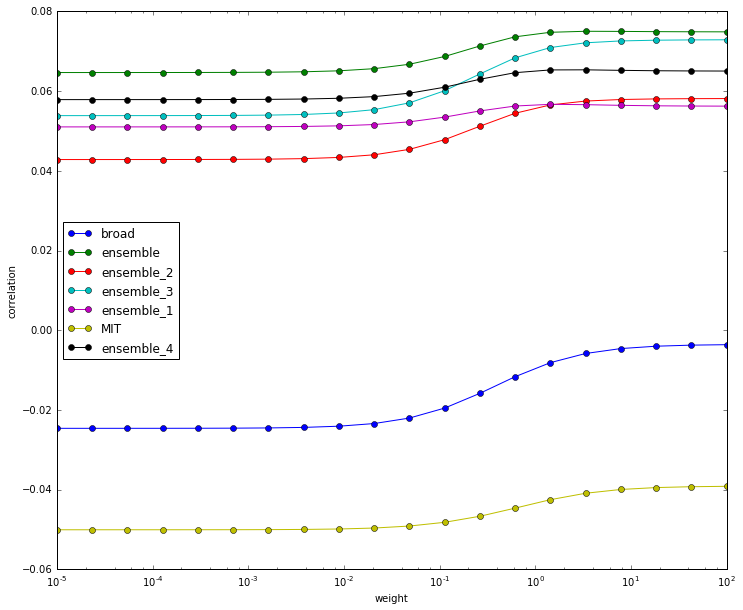

In [19]:
_ = elevation.prediction_pipeline.plot_spearman_with_different_weights(preds, y_rank, 
                                                                    weights=np.logspace(np.log10(0.00001), np.log10(100), 20))
plt.xscale('log')
print target_celltype